In [1]:
import sys
sys.path.extend(['..', '../bgspy'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [114]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

from bgspy.utils import get_files, load_pickle, rel_error, abs_error
from bgspy.optim import optim_diagnotics_plot

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [40]:
from bgspy.likelihood import negll_simplex

def neutral_params(nt, nf, pi0, mu):
    W = np.zeros((nt, nf))
    #W[0, :] = 1  # all neutral
    theta = np.empty(2 + nt*nf)
    theta[0] = pi0
    theta[1] = mu
    theta[2:] = W.flat
    return theta

def null_negloglik(fit):
    Y = fit.Y
    nS, nD = Y.T
    pi0 = nD.sum() / (nS.sum()+nD.sum())
    log_pi = np.log(pi0)
    ll = np.sum(nD*log_pi + nS*np.log1p(-np.exp(log_pi)))
    return -ll

def lik_ratio(fit):
    ll_full = -fit.nll_
    ll_reduced = -null_negloglik(fit)
    LR = -2 * (ll_reduced - ll_full)
    return LR


## Load Data

In [4]:
DIR_default = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed/mle/default/1000000/N__1000/synthetic__chr1_chr2_chr3/'
DIR_full = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed/mle/full/1000000/N__1000/synthetic__chr1_chr2_chr3/'
mles = get_files(DIR_default, '_mle.pkl') + get_files(DIR_full, '_mle.pkl')

In [72]:
from copy import copy
import warnings
from tqdm import tqdm
import os

def merge_chrom_metadata(md, ignore=('chrom', 'chrom_length', 'subs', 'dfe', 'recmap_file', 'seqlens_file', 'sim_tree_file')):
    """
    The simulation trees come in with *a lot* of metadata. This is all in a dictionary
    per-individul-sim, but each MLE fit is on a synthetic chromosome. So this checks
    that all metadata not in ignore (i.e. will be unique per sim ) is the same.
    and outputs it.
    """
    params = []
    def unpack(x):
        if isinstance(x, list) and len(x) == 1:
            return x[0]
        return x
    # the Bs file is packaged with the chromosome metedata, extract it first
    bs_file = md.pop('bs_file')
    for chrom, dat in md.items():
        row = {k: unpack(dat[k]) for k in dat.keys() if k not in ignore}
        if len(params):
            assert list(row.values()) == list(params[-1].values()), (row, params[-1])
        params.append(row)
    md = params[-1]
    md['bs_file'] = bs_file
    return md


def read_fixed_sh_sim_fits(mle_files):
    rows = []
    for fit_file in tqdm(mle_files):
        fits = load_pickle(fit_file)
        mb, mbp = fits['mb'], fits['mbp']
        mb_md = merge_chrom_metadata(mb.metadata)
        mbp_md = merge_chrom_metadata(mbp.metadata)        
        assert mb_md == mbp_md, "B and B' having differing metadata!"
        row = dict(mbp_md)
        # now get the fits for each chromosome
        for model, model_fit in fits.items():
            LR = lik_ratio(model_fit)
            row = copy(row)
            theta = model_fit.param_dict()
            row['model'] = model
            row['LR'] = LR
            row[f'est_mu'] = model_fit.mle_mu
            row[f'est_pi0'] = model_fit.mle_pi0
            sim_sh = int(np.round(np.log10(row['sh']), 8))
            W = np.array(model_fit.mle_W)
            with np.errstate(under='ignore'):
                row['R2'] = model_fit.R2()
                row['est_mean_sh'] = np.average(model_fit.t, weights=W[:, 0])
            row['features'] = '-'.join(model_fit.features)
            row['sh_rel_error'] = rel_error(row['est_mean_sh'], row['sh'])
            rows.append(row)
    return pd.DataFrame(rows)


d = read_fixed_sh_sim_fits(mles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:15<00:00, 15.95it/s]


In [6]:
a = load_pickle('../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed/mle/default/1000000/N__1000/synthetic__chr1_chr2_chr3/mu__1.5e-08/sh__0.005/rep0_seed214029935_mle.pkl')['mbp']

In [7]:
b = load_pickle('../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed/mle/default/1000000/N__1000/synthetic__chr1_chr2_chr3/mu__1.5e-08/sh__1e-4/rep0_seed986036104_mle.pkl')['mbp']

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

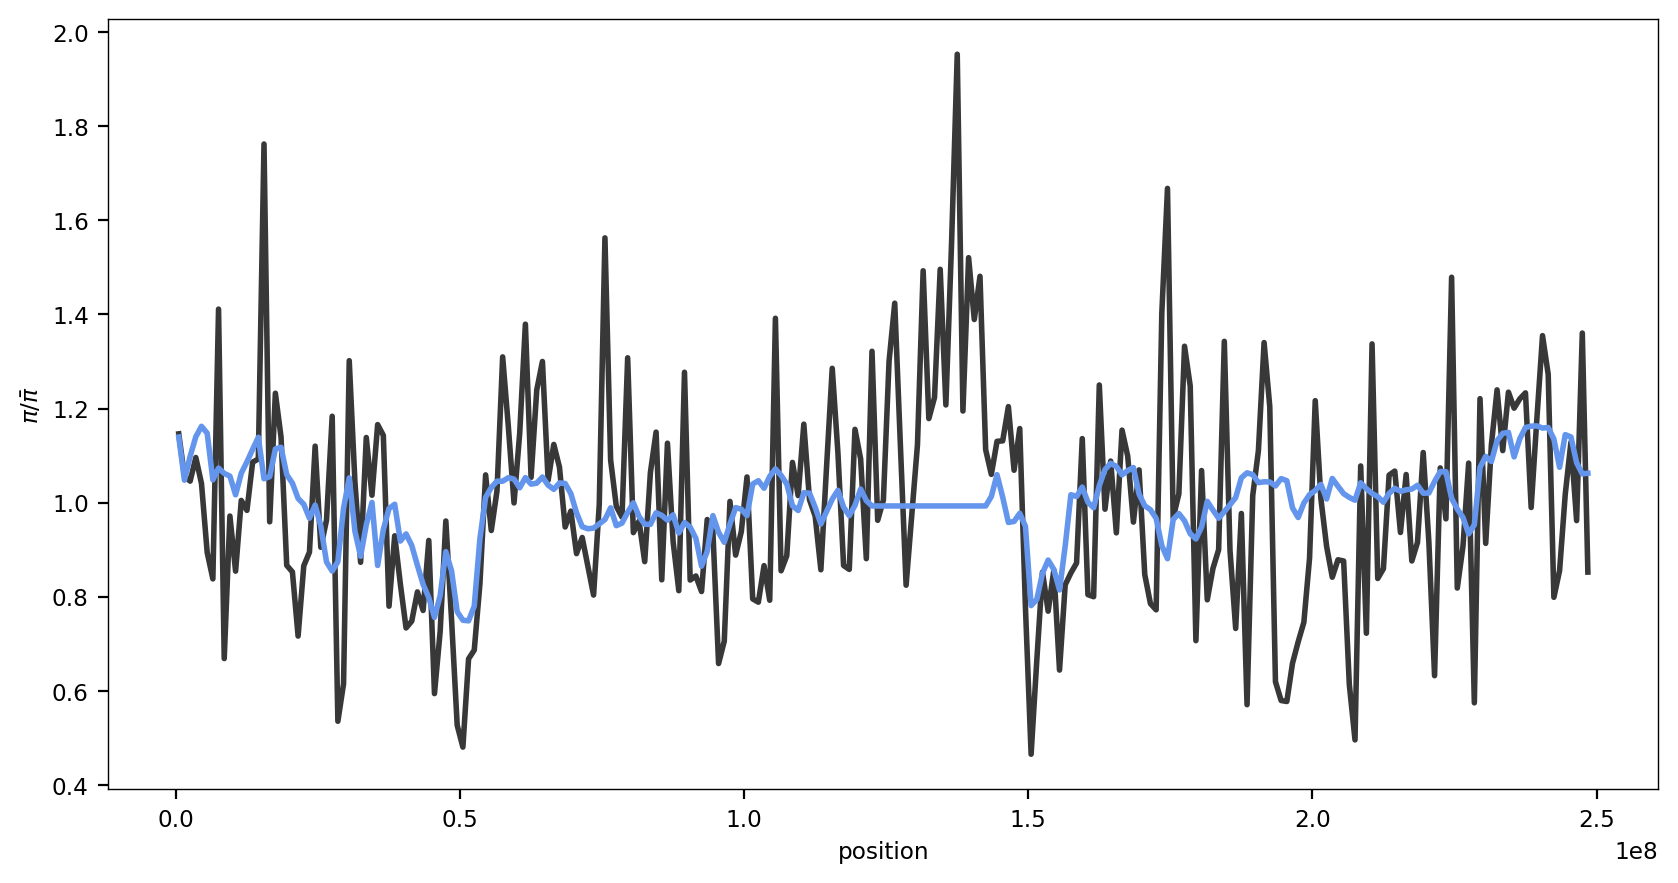

In [8]:
a.predict_plot('chr1')

In [9]:
from bgspy.likelihood import negll_simplex

def neutral_params(nt, nf, pi0, mu):
    W = np.zeros((nt, nf))
    #W[0, :] = 1  # all neutral
    theta = np.empty(2 + nt*nf)
    theta[0] = pi0
    theta[1] = mu
    theta[2:] = W.flat
    return theta

def null_negloglik(fit, mu):
    Y = fit.Y
    nt, nf = fit.nt, fit.nf
    nS, nD = Y.T
    pi0 = nD.sum() / (nS.sum()+nD.sum())
    theta = neutral_params(nt, nf, pi0, mu)
    return negll_simplex(theta, Y, fit.logB_fit, fit.w)#, theta
    
null_negloglik(a, 1e-8)#, a.nll_

8943046906412.72

In [16]:
def null_negloglik(fit):
    Y = fit.Y
    nS, nD = Y.T
    pi0 = nD.sum() / (nS.sum()+nD.sum())
    log_pi = np.log(pi0)
    ll = np.sum(nD*log_pi + nS*np.log1p(-np.exp(log_pi)))
    return -ll

In [36]:
def lik_ratio(ll_reduced, ll_full):
    LR = -2 * (ll_reduced - ll_full)
    return LR

# a is strong sel
f = a
ll0 = -null_negloglik(f)
ll = -f.nll_
ll, ll0, ll > ll0, lik_ratio(ll0, ll)

(-8936704207389.111, -8943046906412.719, True, 12685398047.214844)

In [37]:
# b is weak sel
f = b
ll0 = -null_negloglik(f)
ll = -f.nll_
ll, ll0, ll > ll0, lik_ratio(ll0, ll)

(-11041667931893.775, -11041667931848.965, False, -89.62109375)

(<Figure size 2000x1000 with 3 Axes>,
 array([<Axes: ylabel='merged'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

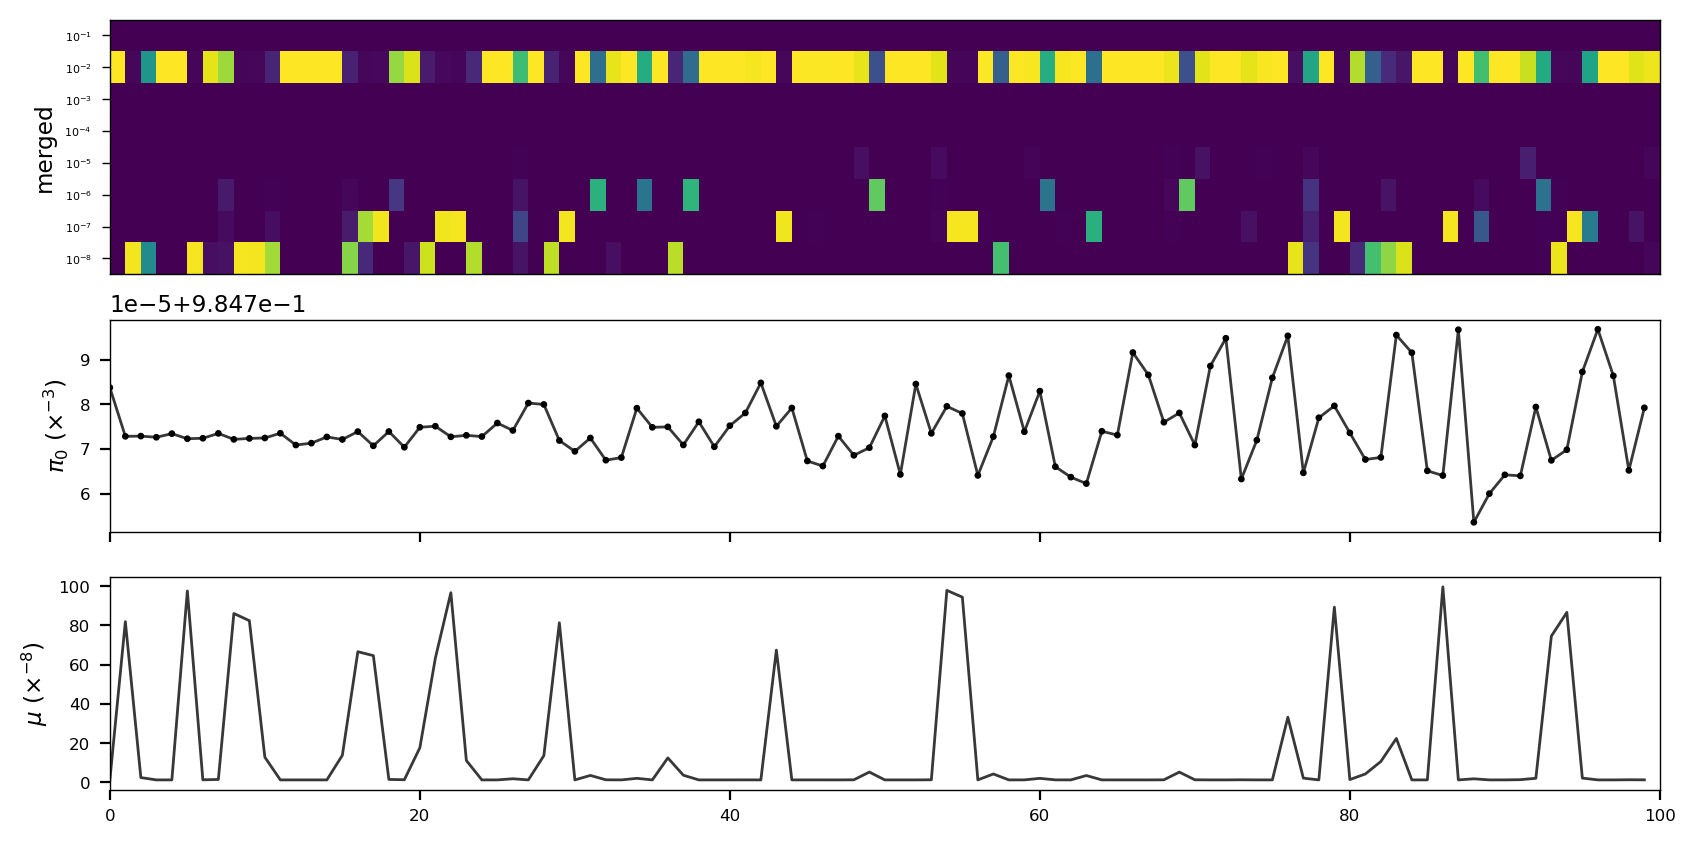

In [13]:
optim_diagnotics_plot(a )

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

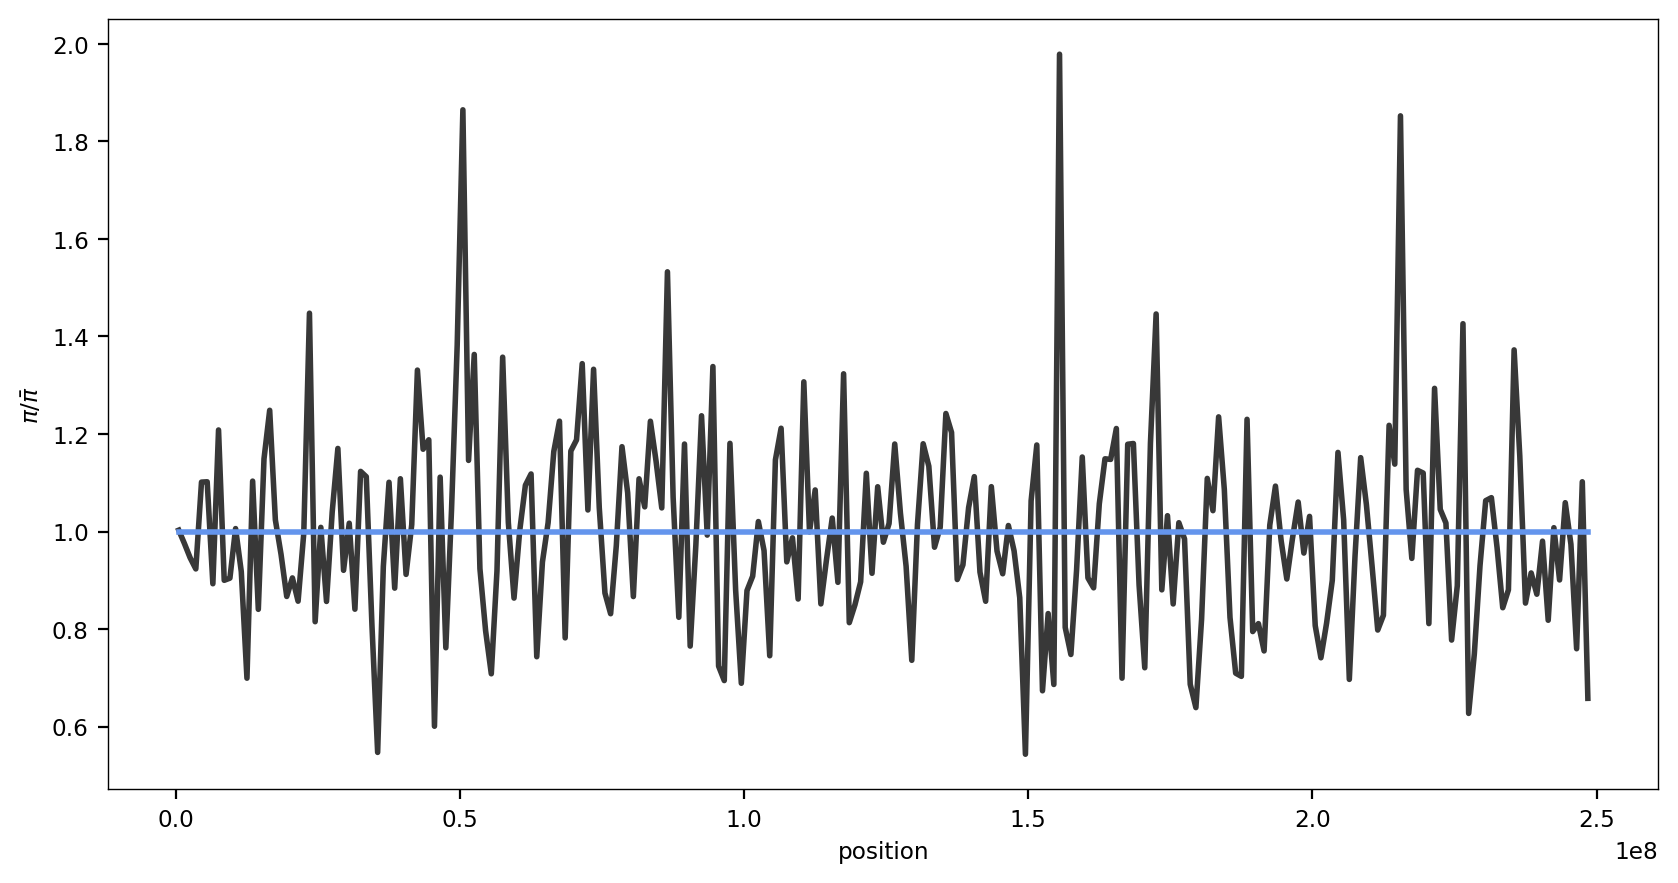

In [537]:
b.predict_plot('chr1')

In [73]:
d['track_type'] = [dict(default='conserved only track', full='whole genome track')[x.replace('bmap__', '').replace('.pkl', '')] for x in d['bs_file']]
model_labels = dict(mb='classic B', mbp="new B'")
d['type'] = [f"{track}, {model_labels[model]}" for track, model in zip(d['track_type'], d['model'])]
d['log10_sh'] = np.log10(d['sh'])
d['log10_est_mean_sh'] = np.log10(d['est_mean_sh'])

#d['log10_sh'] = np.log10(d['sh'])
#d['log10_est_mean_sh'] = np.log10(d['est_mean_sh'])

In [101]:
dg = d.groupby(['sim_mu', 'N', 'annot_file', 'h', 'mu', 'name', 'sh', 'bs_file', 'model', 'features', 'track_type', 'type']).mean().reset_index()

In [115]:
dg['sh_rel_error'] = [rel_error(est, real, as_percent=False) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['sh_abs_error'] = [abs_error(est, real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['bias'] = [(est-real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]

Text(0.5, 0, 'simulated selection coefficient')

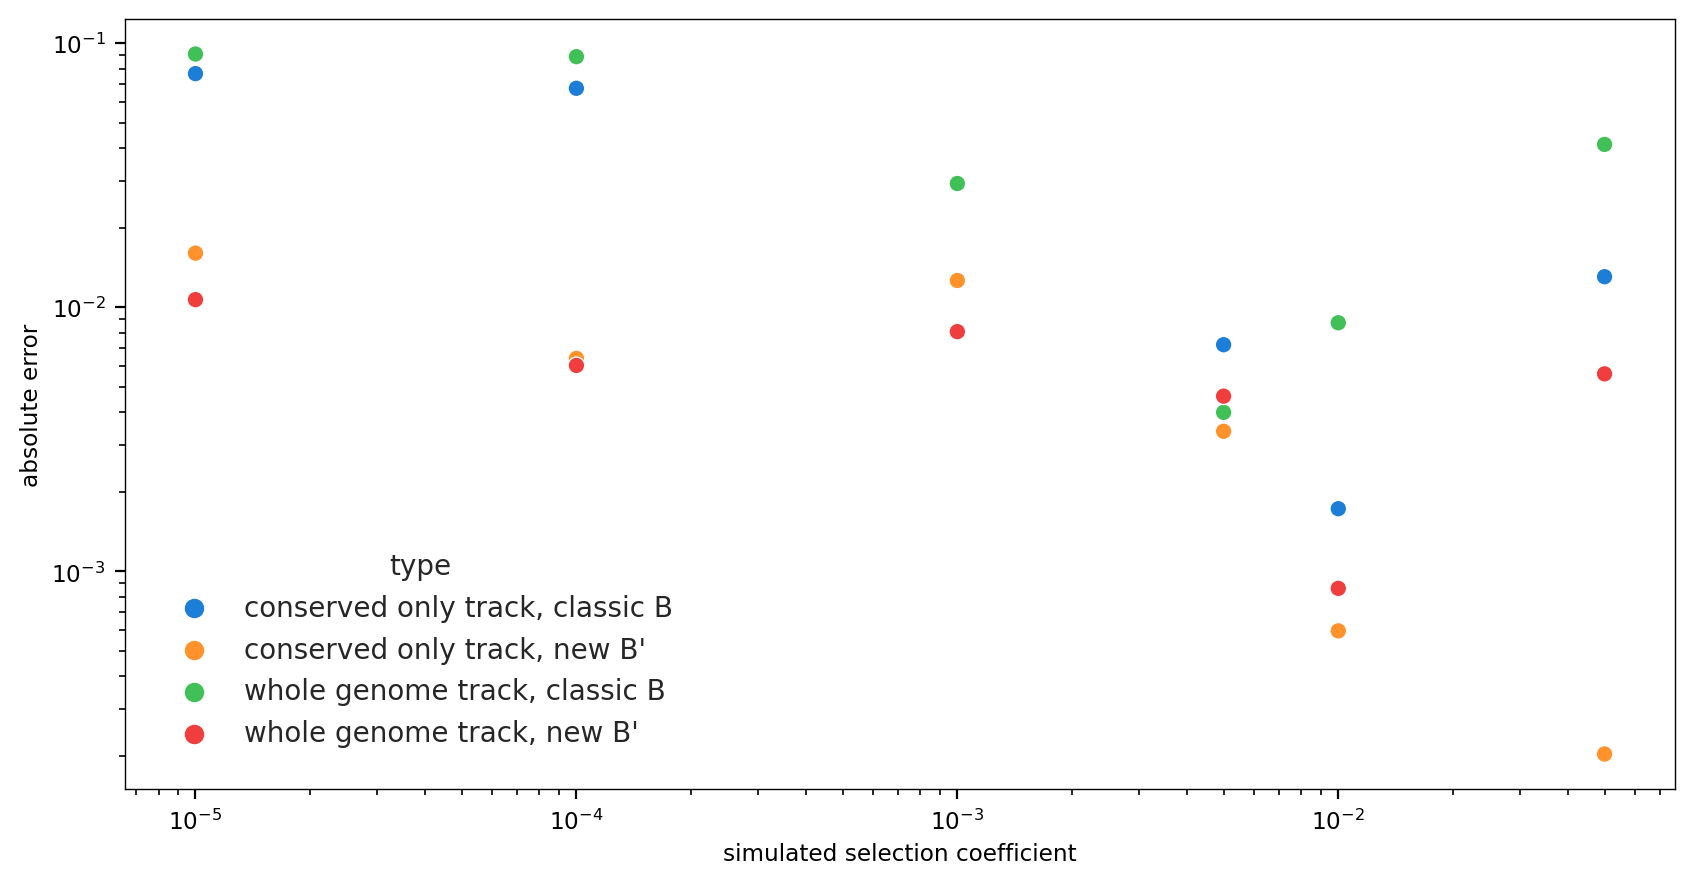

In [118]:
df = dg.loc[dg['mu'] == 1.5e-8]
fig, ax = plt.subplots()
sns.scatterplot(x='sh', y='sh_abs_error', data=df, hue='type', ax=ax)
ax.set_yscale('log')
#ax.grid()
ax.semilogx()
ax.set_ylabel('absolute error')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

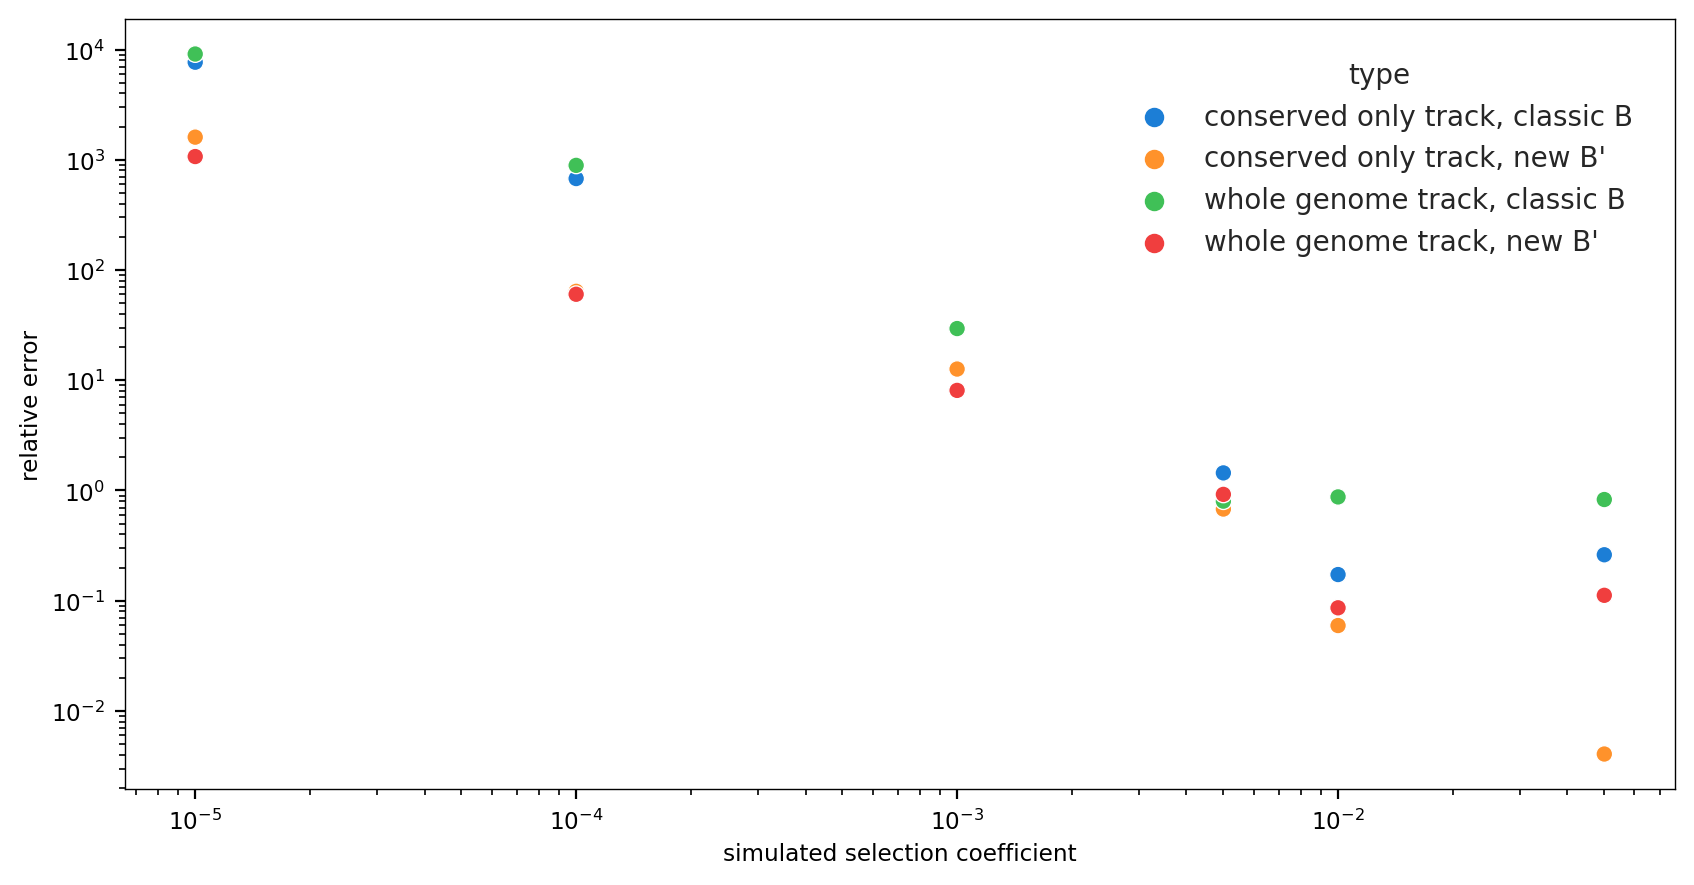

In [119]:
df = dg.loc[dg['mu'] == 1.5e-8]
fig, ax = plt.subplots()
sns.scatterplot(x='sh', y='sh_rel_error', data=df, hue='type', ax=ax)
ax.set_yscale('log')
#ax.grid()
ax.semilogx()
ax.set_ylabel('relative error')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

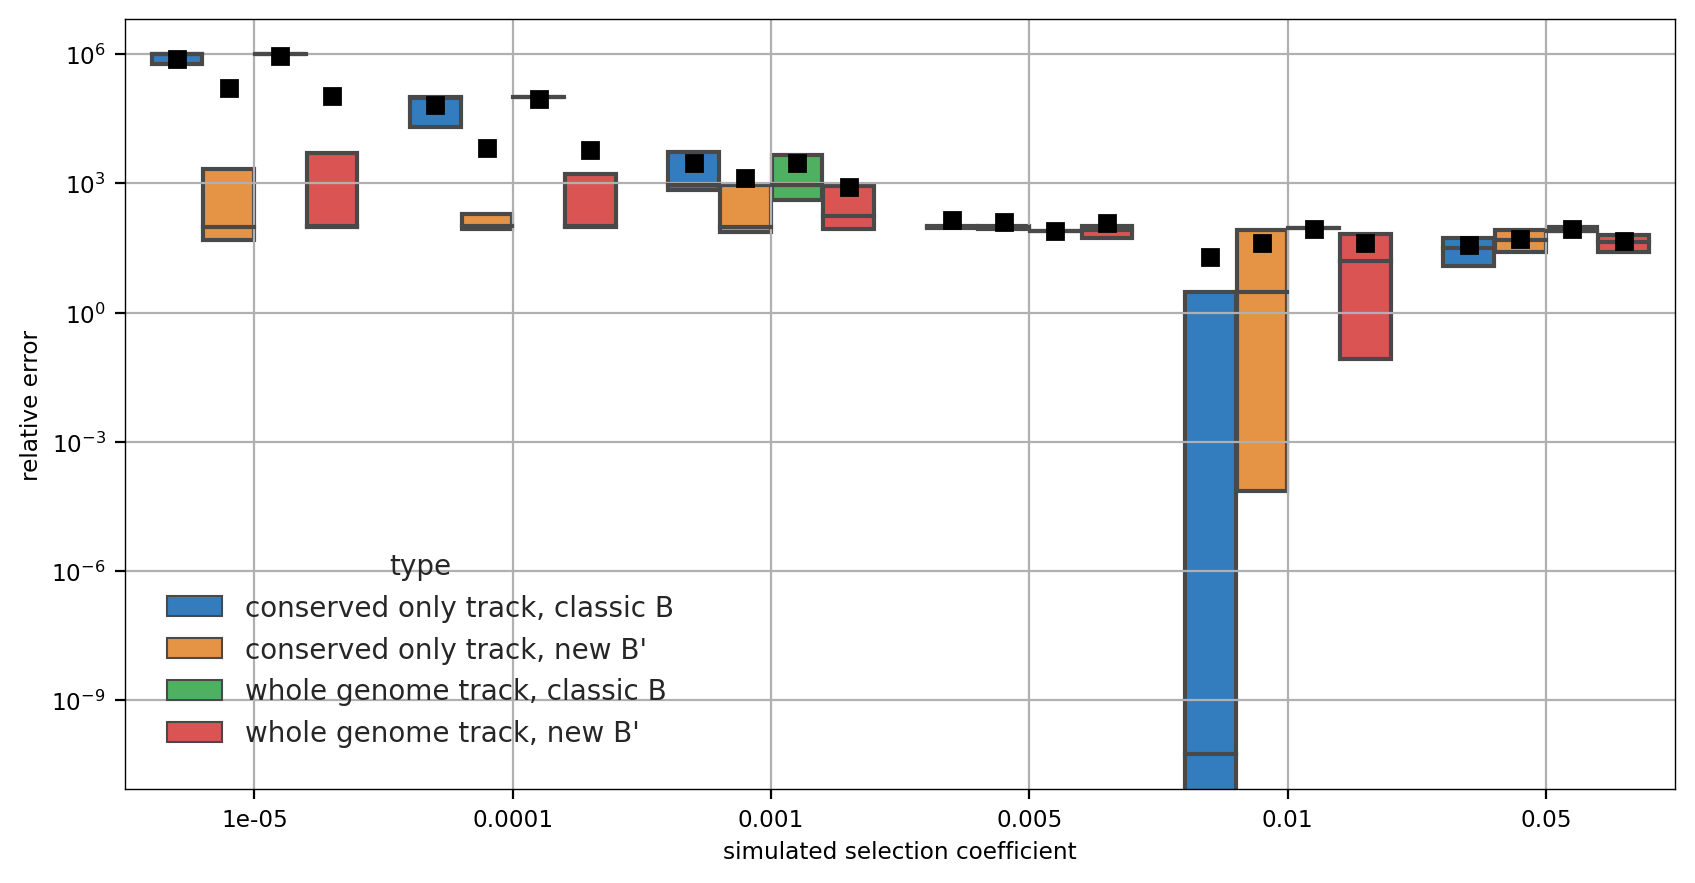

In [120]:
df = d.loc[d['mu'] == 1.5e-8]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='sh_rel_error', data=df, hue='type', ax=ax, whis=False, showmeans=True)
ax.set_yscale('log')
ax.grid()
ax.set_ylabel('relative error')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

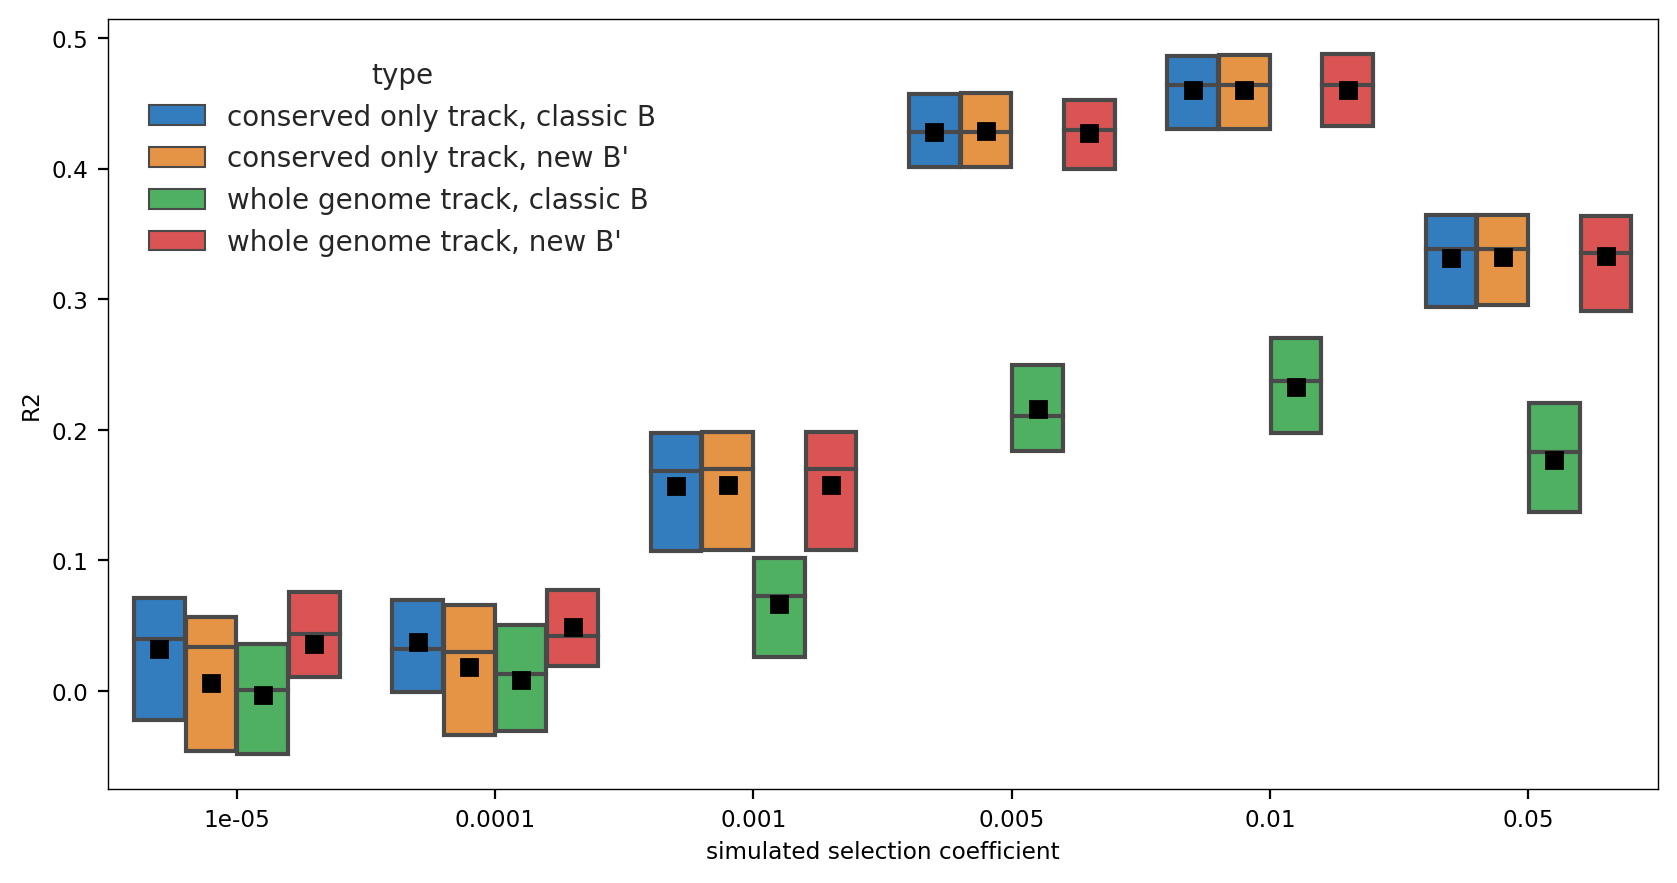

In [121]:
df = d.loc[d['mu'] == 1.5e-8]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='R2', data=df, hue='type', ax=ax, whis=False, showmeans=True)
#ax.set_yscale('symlog')
ax.set_ylabel('R2')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

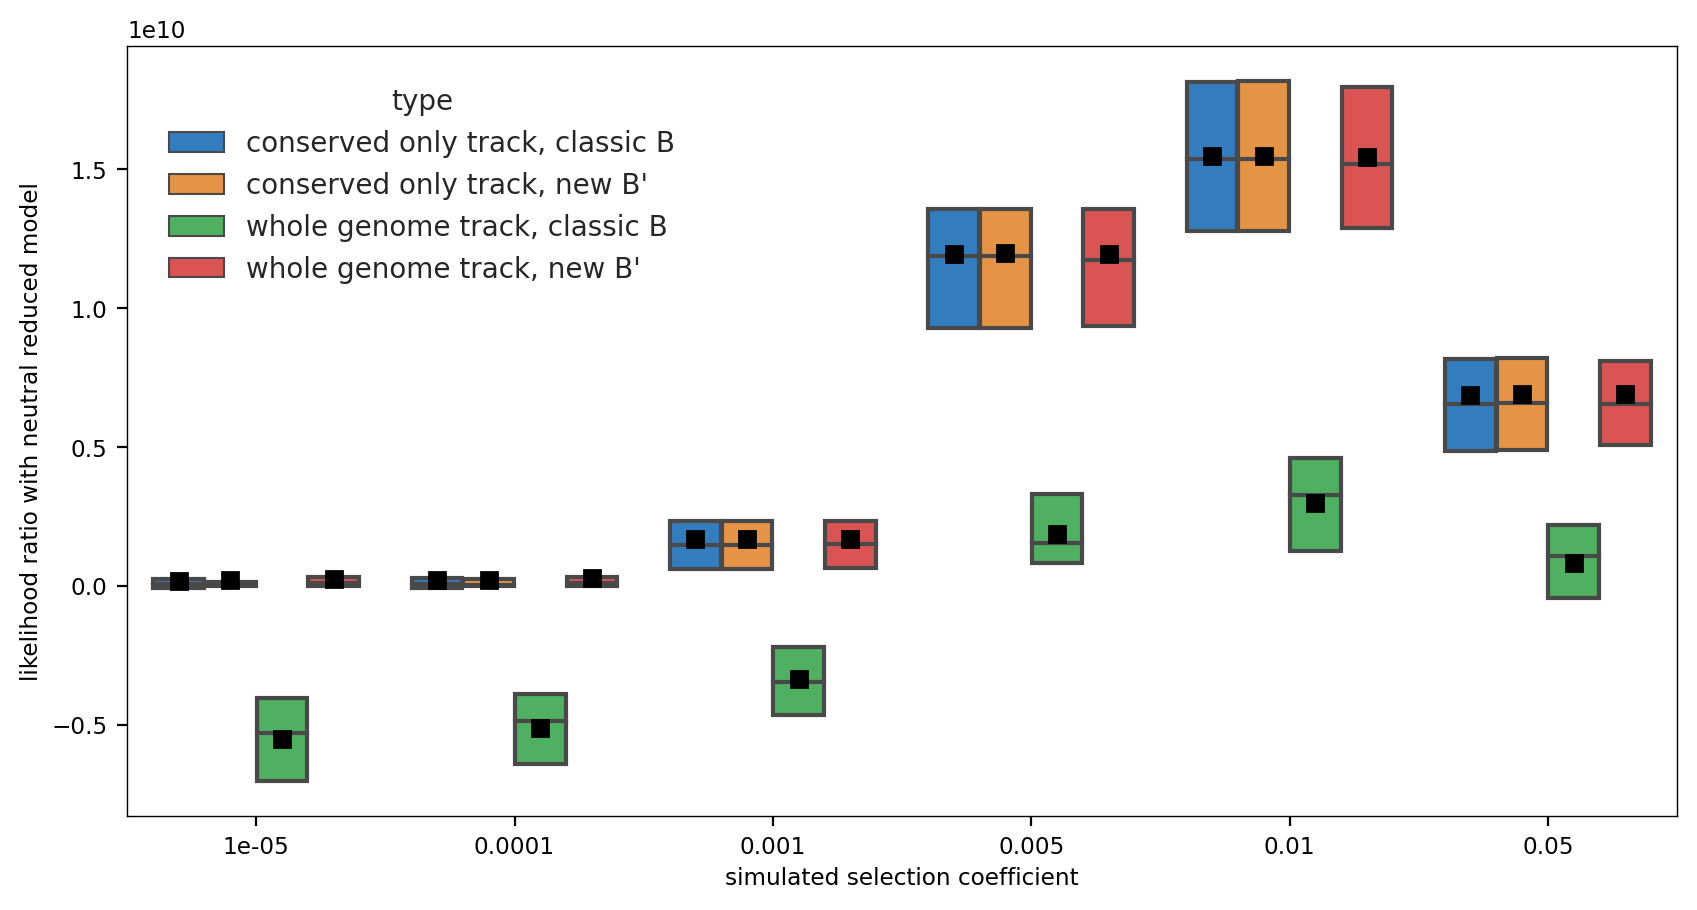

In [62]:
df = d.loc[d['mu'] == 1.5e-8]

fig, ax = plt.subplots()
sns.boxplot(x='sh', y='LR', data=df, hue='type', ax=ax, whis=False, showmeans=True)
#ax.set_yscale('symlog')
ax.set_ylabel('likelihood ratio with neutral reduced model')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

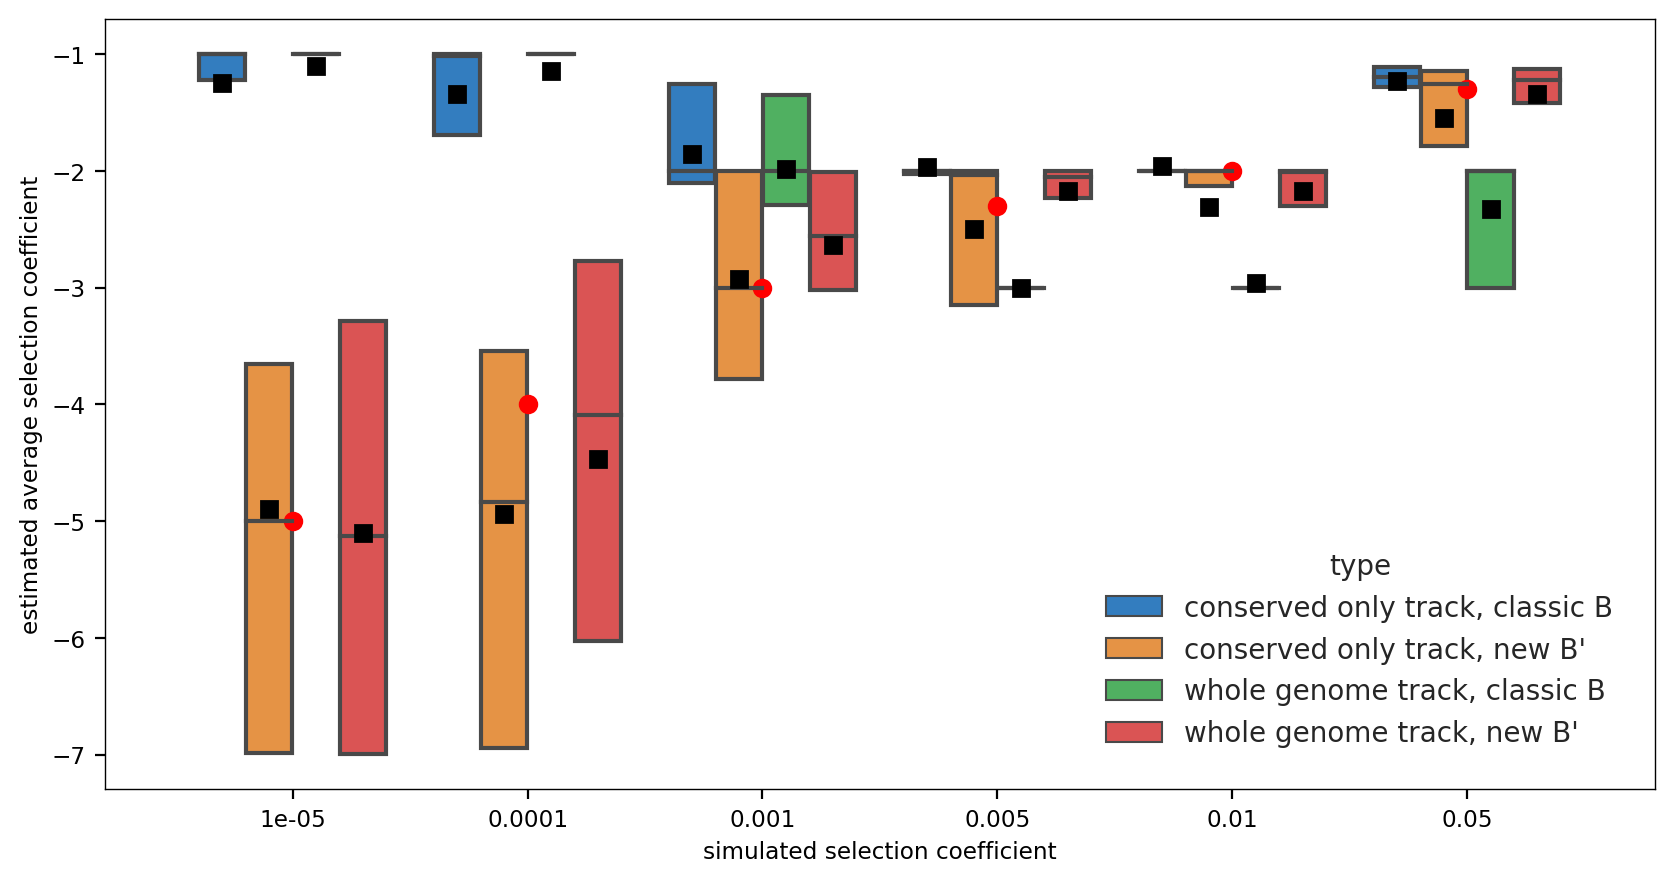

In [68]:
df = d.loc[d['mu'] == 1.5e-8]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax, whis=False, showmeans=True)

x = {i: np.log10(float(x.get_text())) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='r')
#ax.semilogy()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

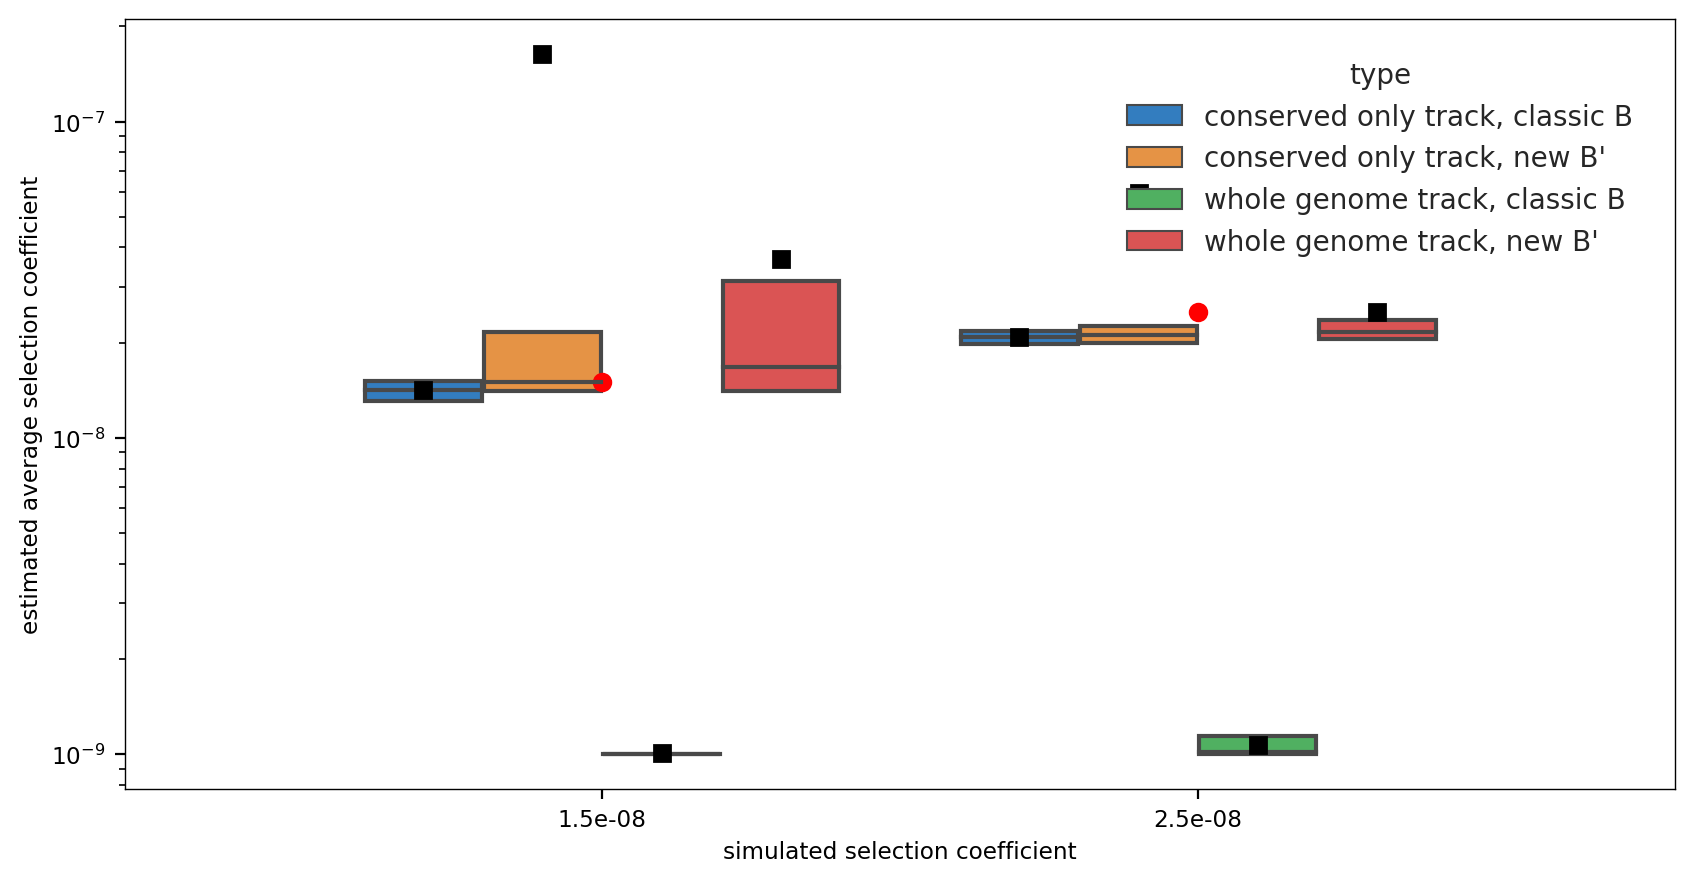

In [64]:
df = d.loc[d['sh'] == 0.01]

fig, ax = plt.subplots()
sns.boxplot(x='mu', y='est_mu', data=df, hue='type', whis=0, ax=ax, showmeans=True)


x = {i: float(x.get_text()) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='r')
ax.semilogy()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

In [109]:
from collections import deque

deque(range(10))

deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<Axes: xlabel='mu', ylabel='est_mu'>

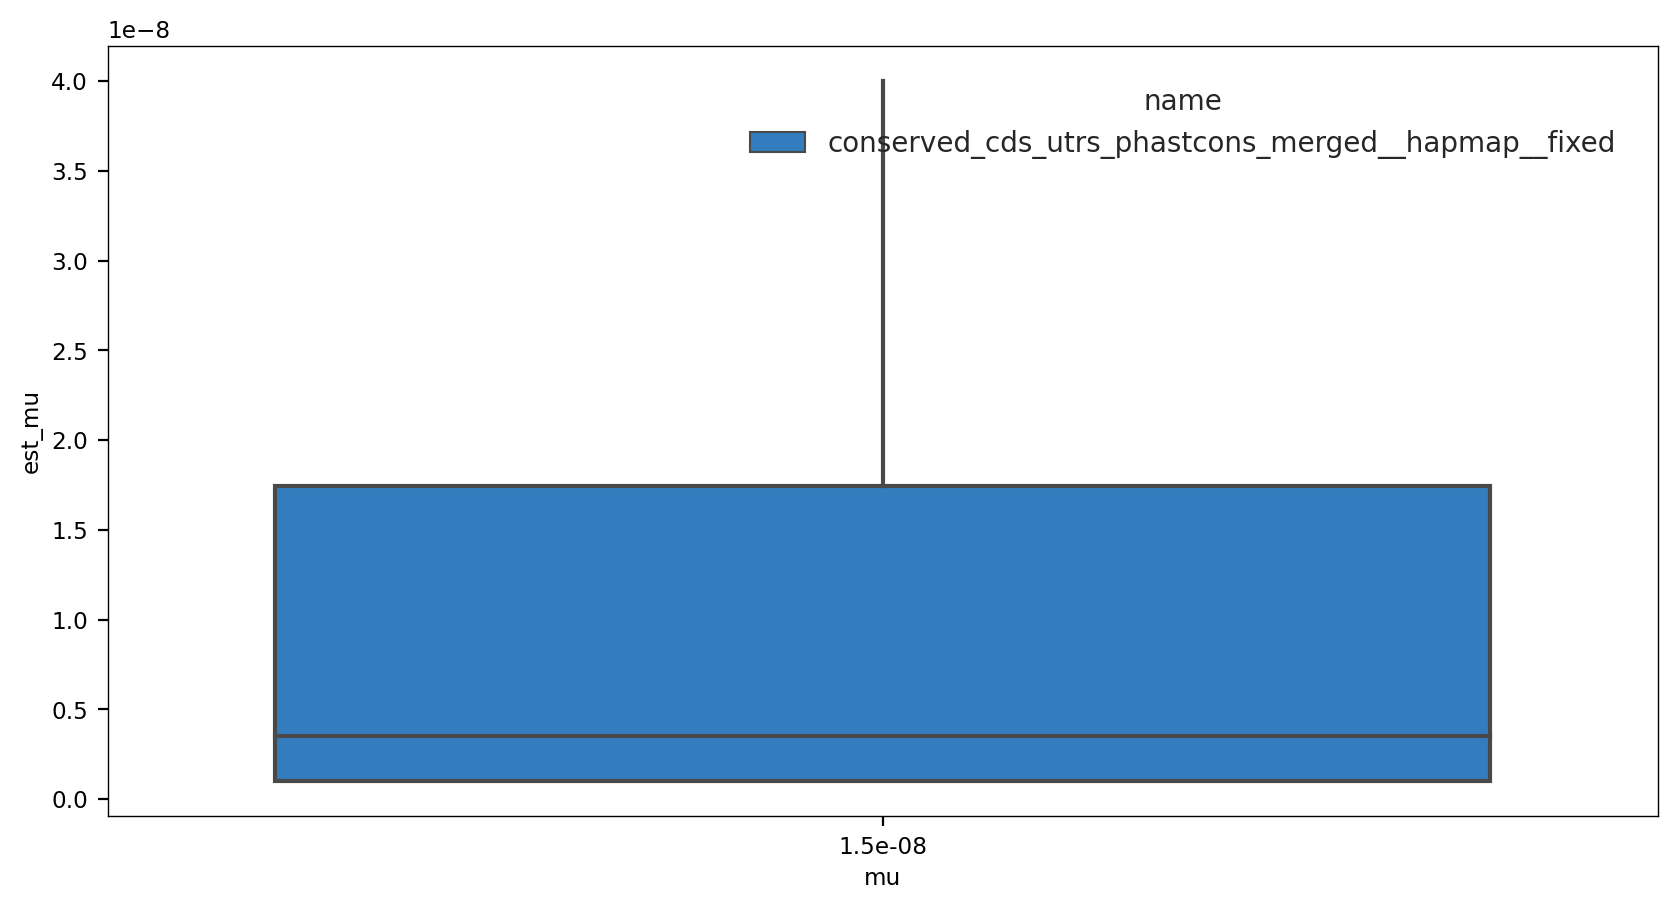

In [96]:
import seaborn as sns

sns.boxplot(x='mu', y='est_mu', hue='name', data=d)

In [18]:
def read_sim_fits(dir, params):
    mles = get_files(dir, '_mle.pkl')
    
    rows = []
    for fit in mles:
        mb, mbp = mles['mb'], mles['mbp']
        # check that B and B' have the same params
        for param in params:
            assert mb.metadata[param] == mbp.metadata[param]
        row = {p: mbp.metadata[param] for p in params}
    
        # now get the fits
        row['theta_b'], row['theta_bp'] = mb.theta_, mbp.theta_
    
    return rows


d = read_sim_fits(DIR, params)

NameError: name 'params' is not defined

In [20]:
DATADIR = "../data/slim_sims/test/"  # TODO - migrated from old repo, needs rename
result_files = os.listdir(DATADIR)

free_pi0s = list()
fixed_pi0s = list()

for file in result_files:
    filename = os.path.join(DATADIR, file)
    if not filename.endswith("fixedpi0ll.pkl"):
        continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res
    fixed_pi0s.append(dict(N=int(md['N']), t=float(md['s'])*float(md['h']), mu=float(md['mu']), pi0=pi0, pi0_mle=pi0_mle, t_mle=t_mle[0], w_mle=w_mle[0]))
    
    
for file in result_files:
    filename = os.path.join(DATADIR, file)
    if not filename.endswith("freepi0ll.pkl"):
        continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res
    free_pi0s.append(dict(N=int(md['N']), t=float(md['s'])*float(md['h']), mu=float(md['mu']), pi0=pi0, pi0_mle=pi0_mle, t_mle=t_mle[0], w_mle=w_mle[0]))

ModuleNotFoundError: No module named 'models'

In [6]:
dfree = pd.DataFrame(free_pi0s)
dfixed = pd.DataFrame(fixed_pi0s)
dfree.head()

,N,t,mu,pi0,pi0_mle,t_mle,w_mle
0,1000,-0.00500,1.500000e-08,0.000588,0.000588,0.006237,9.102982e-09
1,1000,-0.00001,2.000000e-08,0.001141,0.001141,0.562341,1.676833e-09
2,1000,-0.05000,1.500000e-08,0.000411,0.000411,0.088105,2.329952e-08
3,1000,-0.10000,1.500000e-08,0.000595,0.000595,0.088105,1.599859e-08
4,1000,-0.00500,2.000000e-08,0.000407,0.000407,0.004786,5.179475e-09


In [7]:
dfree['w_re'] = rel_error(dfree['mu'], dfree['w_mle'])

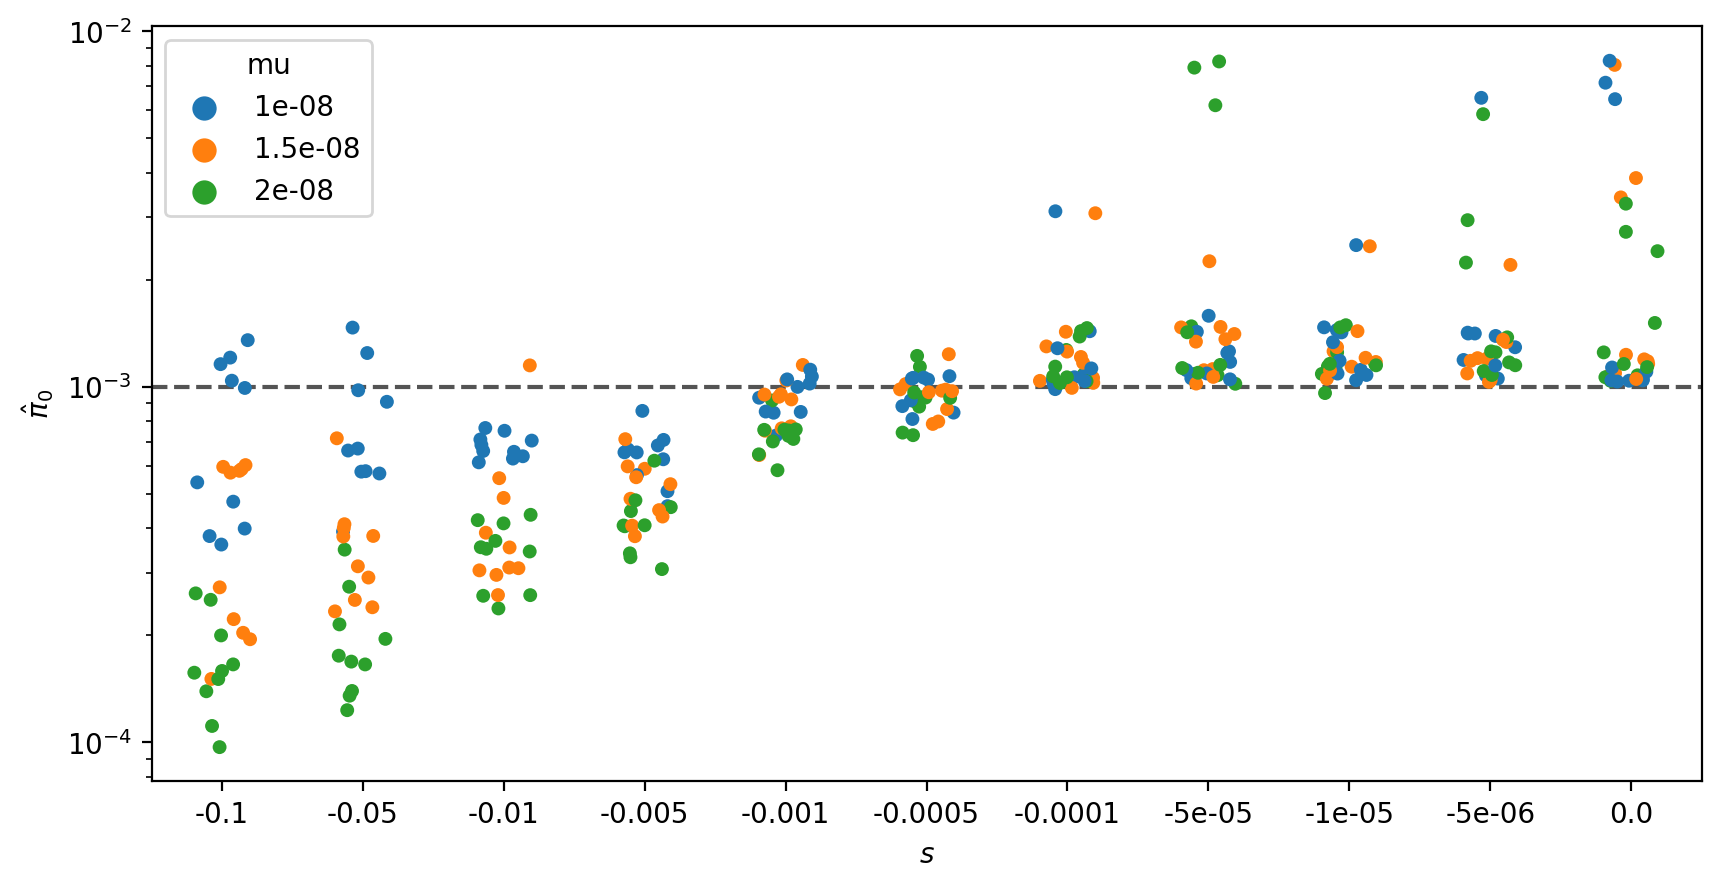

In [8]:
fig, ax = plt.subplots()

sns.stripplot(x="t", y="pi0_mle", data=dfree, hue="mu", jitter=0.2, ax = ax)

ax.axhline(4 * 2.5e-7*1000, c='0.33', linestyle='dashed')
ax.set_yscale('log')
ax.set_ylabel('$\\hat{\\pi}_0$')
ax.set_xlabel('$s$')
#fig.savefig('/home/vsb/pi0.pdf')

## Mutation rate estimation

### Fixed π0

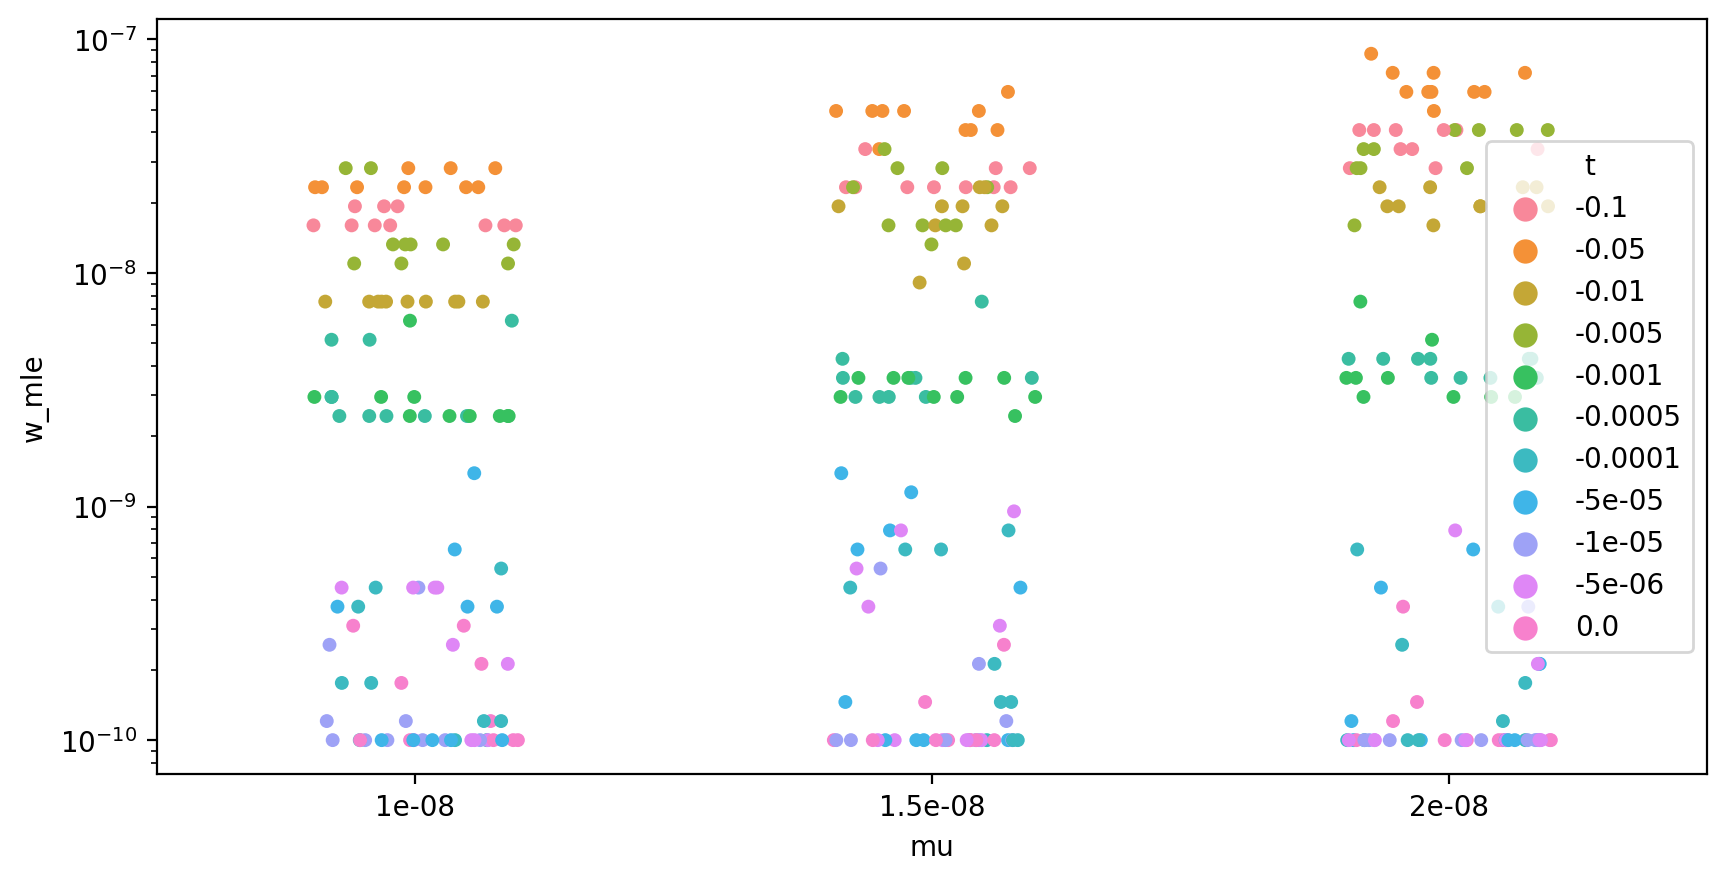

In [31]:
fig, ax = plt.subplots()

sns.stripplot(x="mu", y="w_mle", data=dfixed, hue="t", jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')

### Free π0

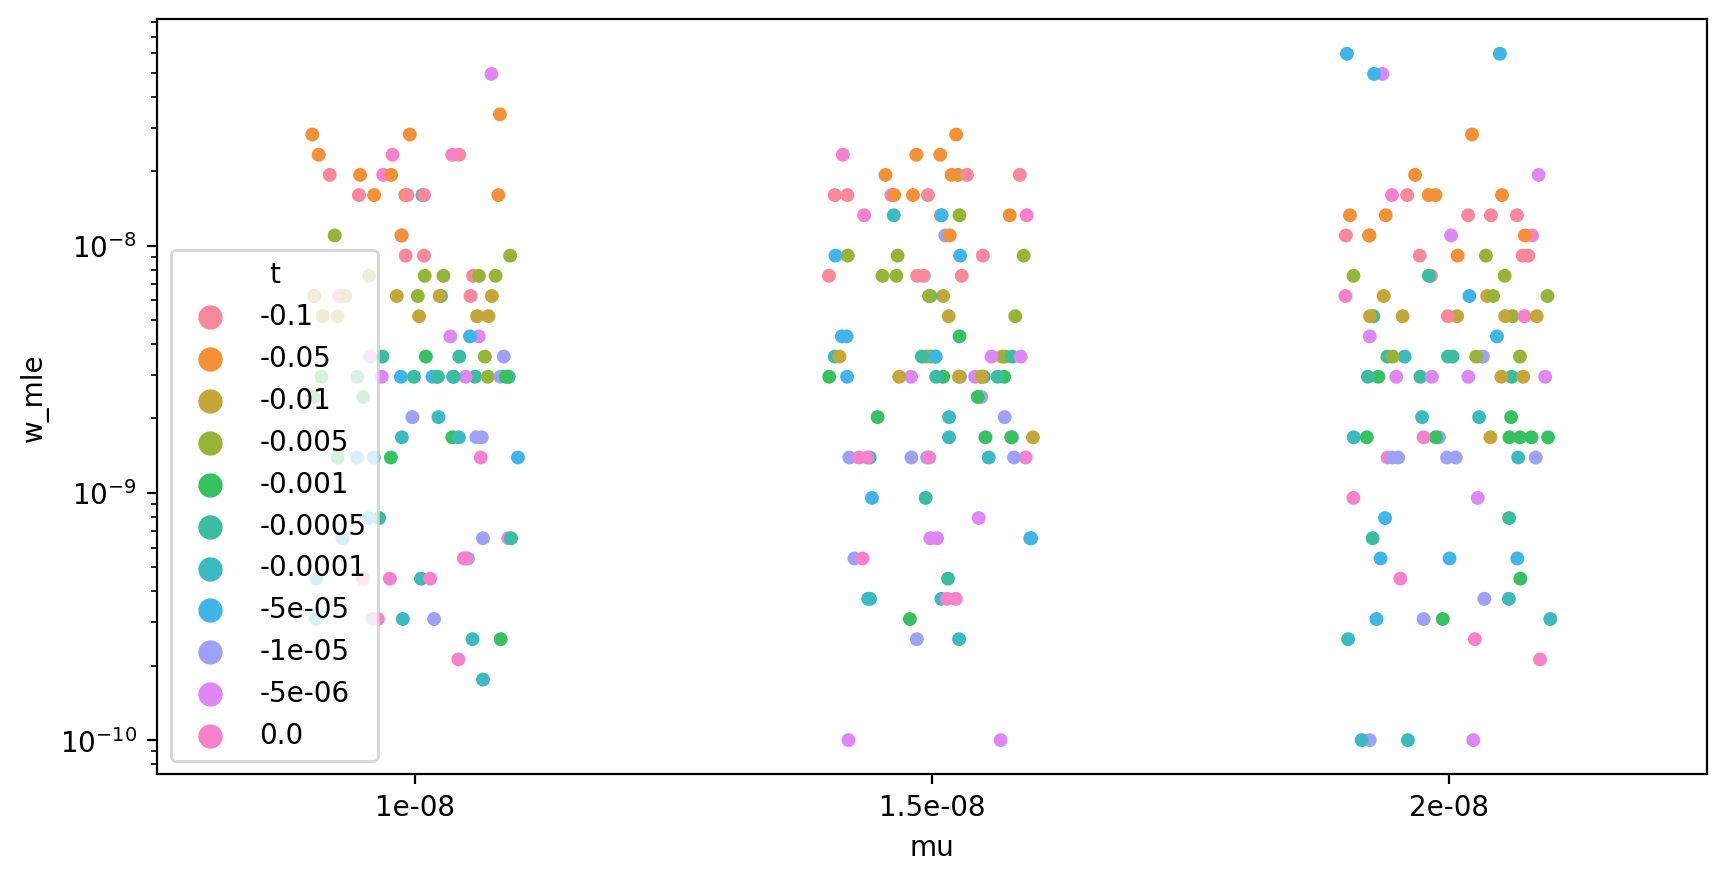

In [32]:
fig, ax = plt.subplots()

sns.stripplot(x="mu", y="w_mle", data=dfree, hue="t", jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')

## Selection coefficient estimation

### Free π0

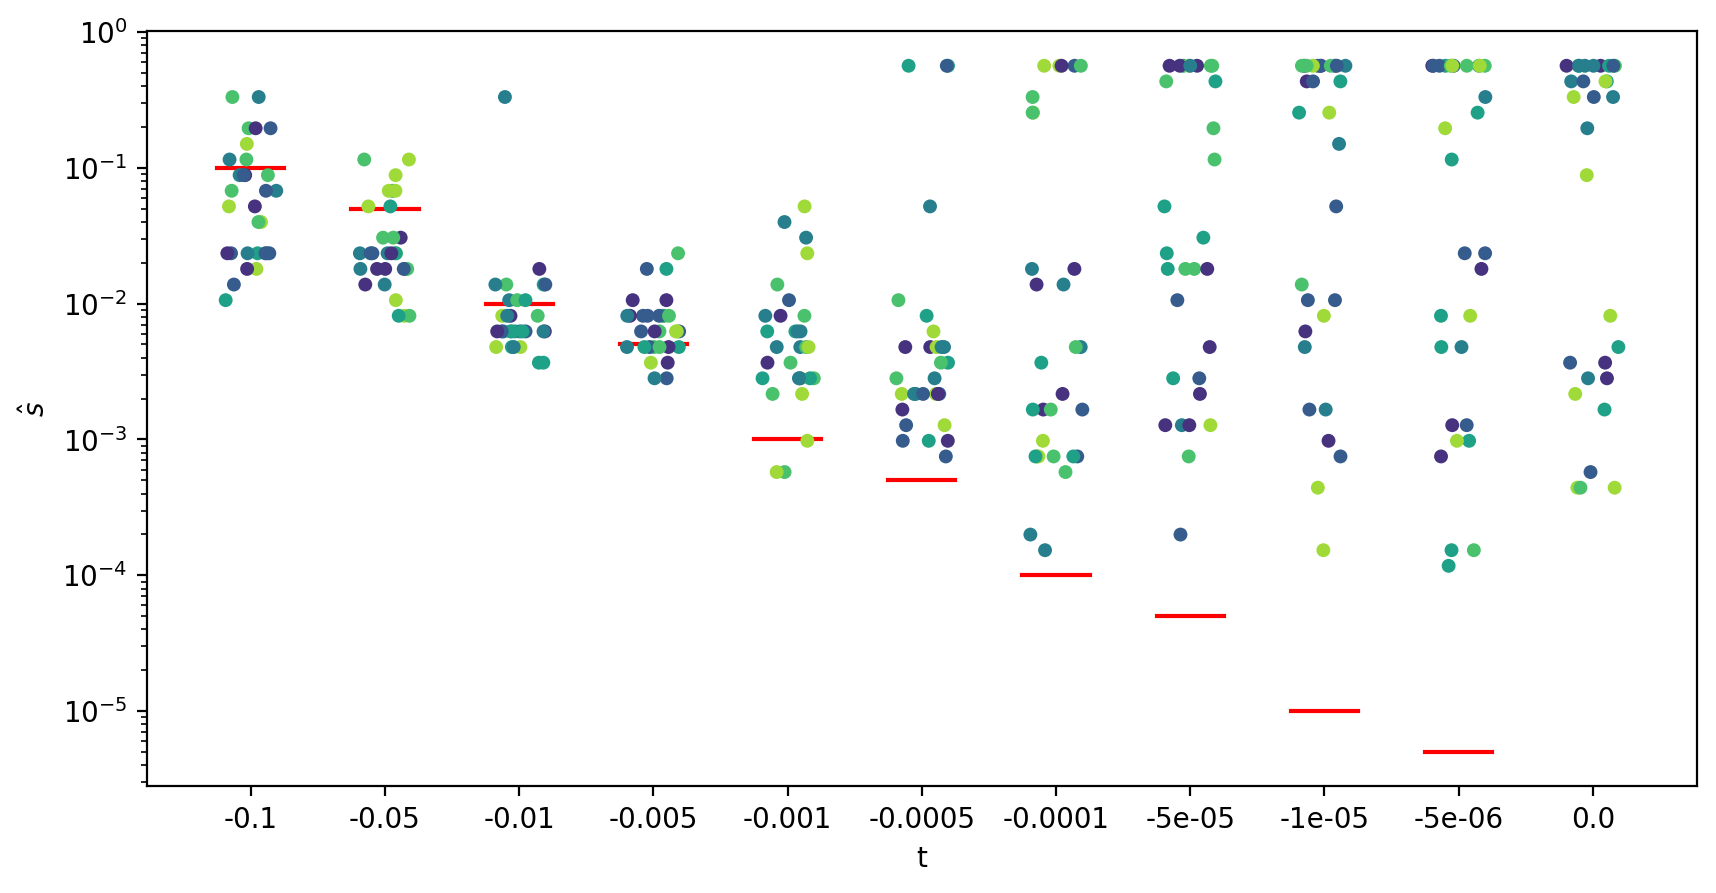

In [97]:
fig, ax = plt.subplots()
cpal = sns.color_palette('viridis')
dfree['pi0_mle_log10'] = np.log10(dfree['pi0_mle'])
sns.stripplot(x="t", y="t_mle", data=dfree, hue="pi0_mle_log10", jitter=0.2, ax=ax, palette=cpal)

median_width = 0.5
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    val = -float(text.get_text())
    ax.plot([tick-median_width/2, tick+median_width/2], [val, val], c='r')
#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.get_legend().remove()
ax.set_yscale('log')
ax.set_ylabel('$\hat{s}$')
#ax.legend()
#fig.colorbar(cmap)
fig.savefig('/home/vsb/s_hat.pdf')


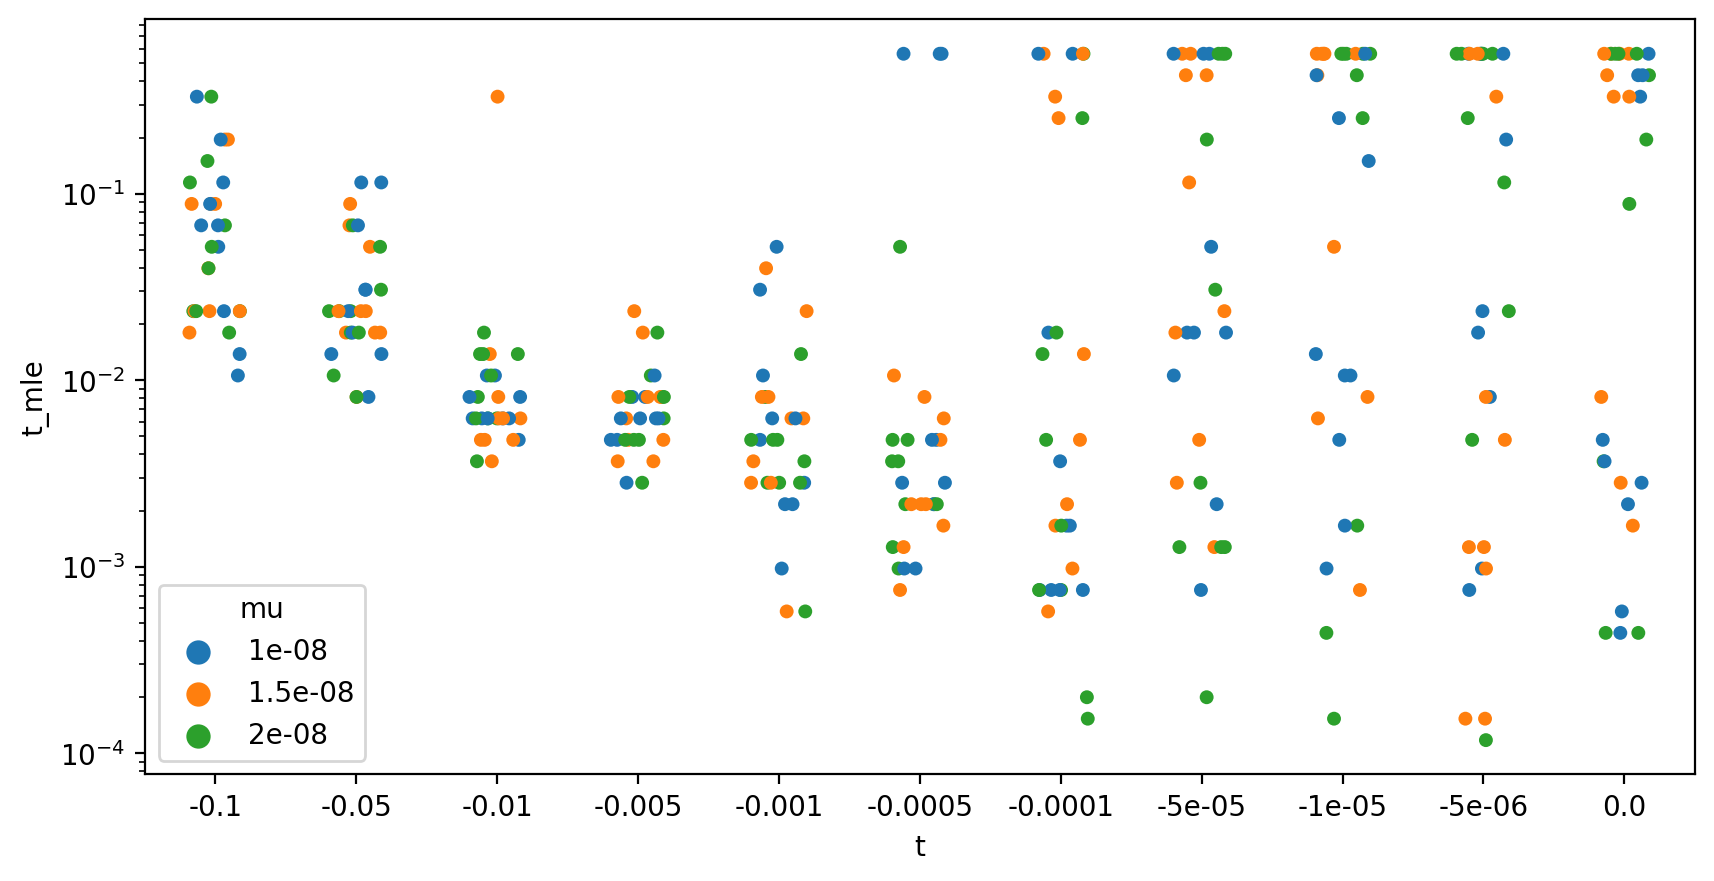

In [54]:
fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(as_cmap=True)

sns.stripplot(x="t", y="t_mle", data=dfree, hue="mu", cmap=cmap, jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
#ax.get_legend().remove()
ax.set_yscale('log')
#fig.colorbar(cmap)


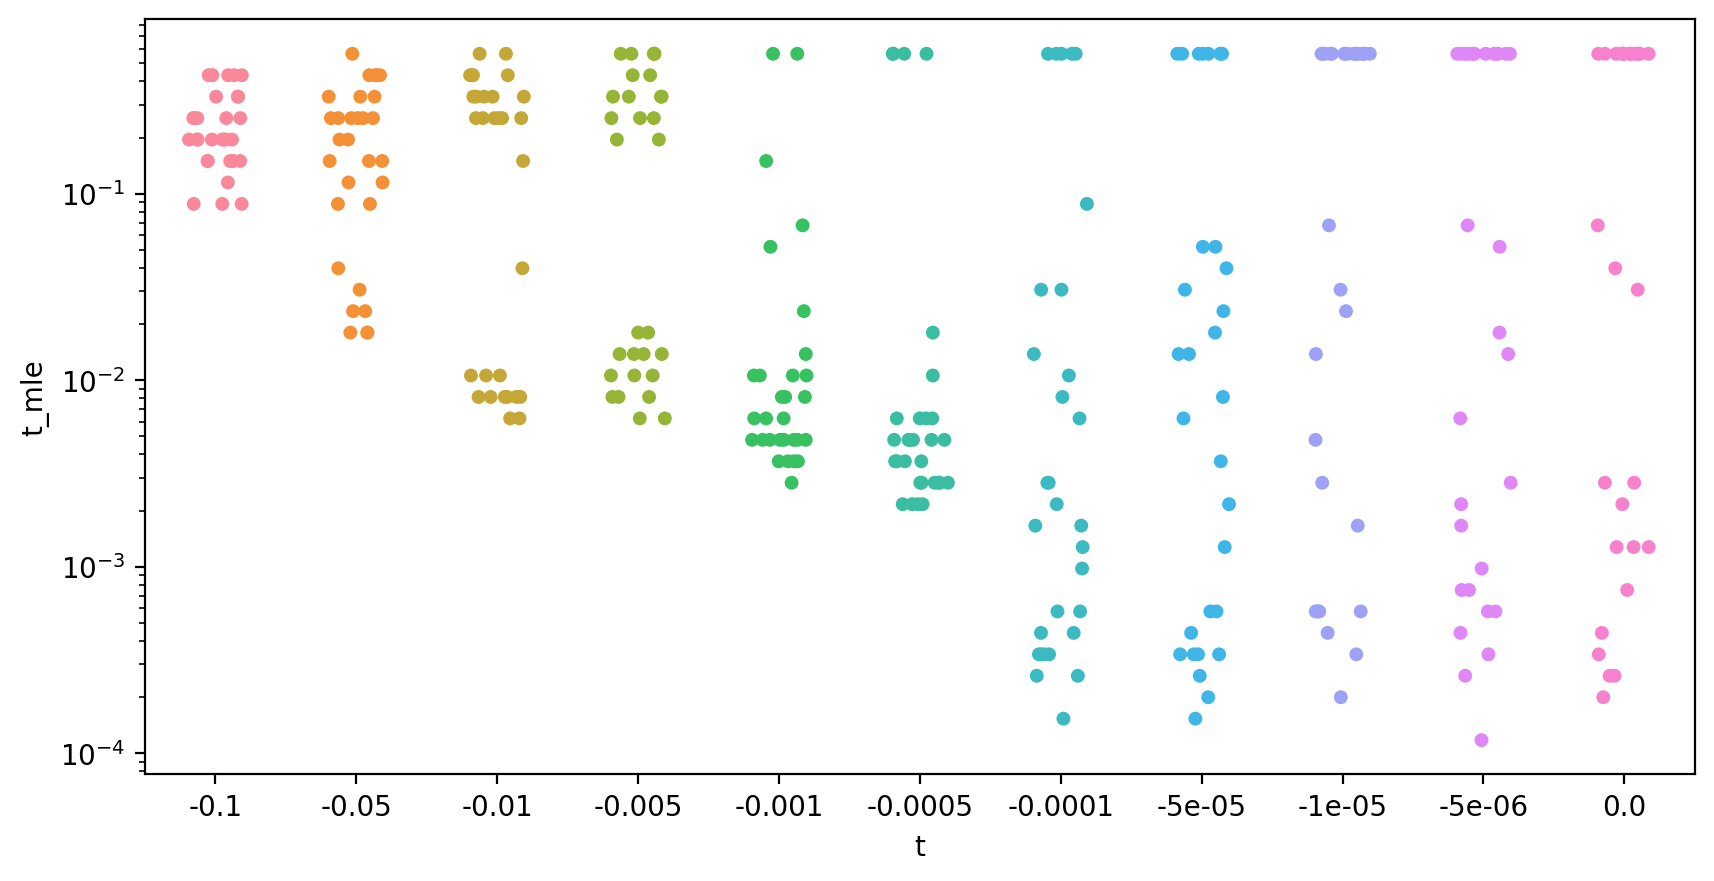

In [34]:
fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(as_cmap=True)

sns.stripplot(x="t", y="t_mle", data=dfixed, cmap=cmap, jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')
#fig.colorbar(cmap)


In [137]:
130000000 * 2.5e-7 * 1000 * 4

130000.0

In [14]:
ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res

In [18]:
pi0, pi0_mle

(0.0011481496987360924, 0.0011481496987360924)

In [19]:
md

{'N': '1000',
 'annot_file': '../data/annotation/conserved_chr10.bed',
 'h': '0.5',
 'mu': '1e-08',
 'recmap_file': '../data/annotation/rec_100kb_chr10.bed',
 'region_length': '130000000',
 's': '-1e-05'}